# Notebook to Normalize Crash Hotspots by traffic density
the idea is to get a normalized Hotpsot indication, i.e. the crash exposure relative to the amount of traffic on that link should be determined

In [36]:
import geopandas as gpd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString, Point
import numpy as np

### Load the required data 

In [2]:
zaehlstelle = gpd.read_file('Files/Jawe2021_us.csv')

In [41]:
unfallorte = gpd.read_file("Files/unfallorte_2022_HW_mapmatched_ref_DBSCAN_same_HW.shp")

In [ ]:
def convert_float(value):
    try: 
        return float(value)
    except ValueError:
        return np.nan

In [47]:
zaehlstelle[['DTV_Kfz_MobisSo_Q', 'Koor_WGS84_N', 'Koor_WGS84_E']] = zaehlstelle[['DTV_Kfz_MobisSo_Q', 'Koor_WGS84_N', 'Koor_WGS84_E']].applymap(convert_float)

## Create Geometries from datframe 

In [48]:
geometry = [Point(Koor_WGS84_E, Koor_WGS84_N) for Koor_WGS84_E, Koor_WGS84_N in zip(zaehlstelle['Koor_WGS84_E'], zaehlstelle['Koor_WGS84_N'])]
gdf_zaehlstelle = gpd.GeoDataFrame(zaehlstelle, geometry=geometry, crs="EPSG:4326")

### Filter to relevant area 

In [49]:
gdf_zaehlstelle = gdf_zaehlstelle[(gdf_zaehlstelle['Koor_WGS84_E']<16) & (gdf_zaehlstelle['Koor_WGS84_N']>46)]

In [50]:
def haversine(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    # Radius of the Earth in meters
    R = 6371000.0  # Approximately 6,371,000 meters

    # Convert latitude and longitude from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Haversine formula
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Calculate the distance in meters
    distance = R * c

    return distance

In [51]:
from geopy.distance import geodesic

def next_messtelle(row1, gdf_zaehlstelle):
    # Iterate through each row in gdf1
    
    min_distance = float('inf')  # Initialize with positive infinity
    nearest_messetelle = None
    nearest_verkehrsstaerke = None
    nearest_gemeinde = None
    n_lat = None
    n_lon = None
    # Iterate through each row in gdf2
    for idx, row2 in gdf_zaehlstelle.iterrows():

        # Calculate the minimum Haversine distance between each coordinate point in the LineString and the point in gdf1
        line_distance = haversine((row1['lat'],row1['lon']), (row2['Koor_WGS84_N'], row2['Koor_WGS84_E']))
        # Check if this row has a smaller distance than the current minimum
        #print (row1['lat'],row1['lon'], row2['Koor_WGS84_N'], row2['Koor_WGS84_E'])
        if line_distance < min_distance:
            #if not np.isnan(row2['DTV_Kfz_MobisSo_Q']):
            if row2['Str_Kl']+' '+ row2['Str_Nr']== row1['ref_y']:
                #print(row2['Str_Kl']+' '+ row2['Str_Nr']== row1['ref_y'])
                min_distance = line_distance
                nearest_messetelle = row2['DZ_Nr']
                nearest_verkehrsstaerke = row2['DTV_Kfz_MobisSo_Q']
                nearest_gemeinde = row2['DZ_Name']
                n_lat = row2['Koor_WGS84_N']
                n_lon = row2['Koor_WGS84_E']
        # Print the nearest "osm_id" and the Haversine distance for each point in gdf1
    print (row1['lat'],row1['lon'], n_lat, n_lon)
    print(f"For point at index {idx}, Nearest Messtelle: {nearest_messetelle}, verkehrsstaerke: {nearest_verkehrsstaerke}")
    print("Haversine Distance (meters):", min_distance, f"UGEMEINDE: {row1['UGEMEINDE']}, Z_Gem: {nearest_gemeinde}, HW: {row1['ref_y']}")
    return nearest_messetelle, min_distance, nearest_verkehrsstaerke

In [ ]:
import math
results_ms = unfallorte.apply(lambda row: next_messtelle(row, gdf_zaehlstelle), axis=1)

# Create two separate lists to hold the results
nearest_messetelle, min_distance, nearest_verkehrsstaerke = zip(*results_ms)

# Add the lists as new columns to the points_in_berlin DataFrame
unfallorte['nearest_messetelle'] = nearest_messetelle
unfallorte['distance_MS'] = min_distance
unfallorte['nearest_verkehrsstaerke'] = nearest_verkehrsstaerke


In [53]:
um = unfallorte['nearest_verkehrsstaerke'].median()

In [54]:
def normal(x,y, um):
    return x if (np.isnan(y) or x/y*um==0 or np.isnan(x/y*um)) else x/y*um
    

In [56]:
unfallorte['normalized_cluster_size'] = unfallorte.apply(lambda row: normal(row['cluster_si'],row['nearest_verkehrsstaerke'],um), axis=1)

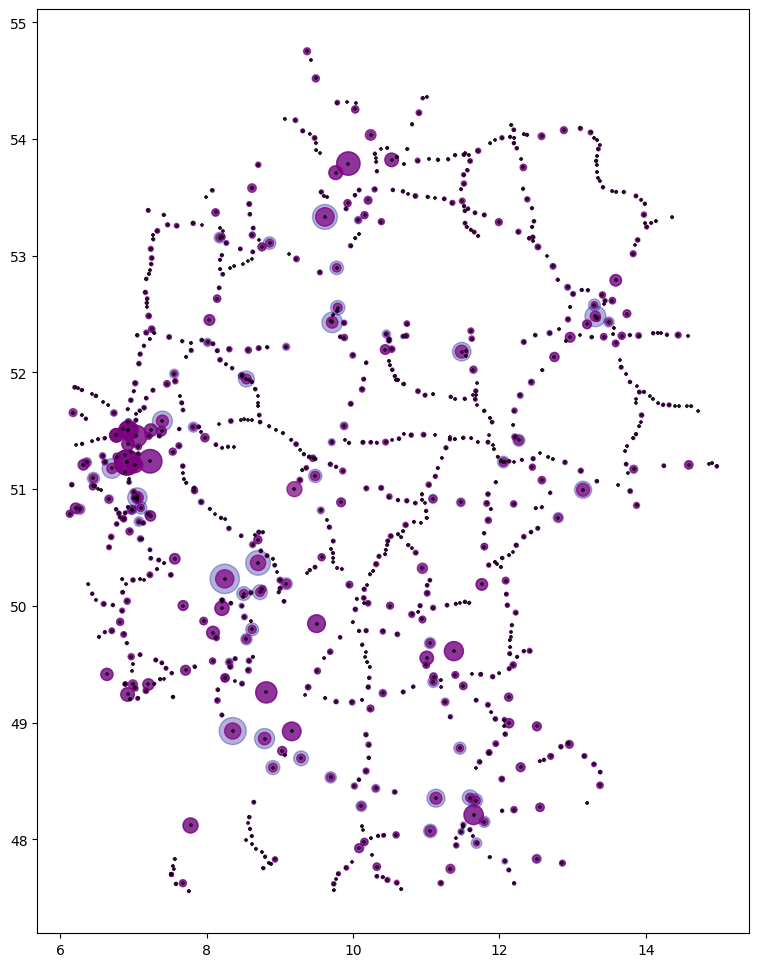

In [57]:
fig, ax = plt.subplots(figsize=(20, 12))

unfallorte.plot(ax=ax, markersize=10, alpha = 0.05, color="gray")
plt.scatter(unfallorte['lon'], unfallorte['lat'], s=unfallorte['cluster_si'], alpha=0.3, color="darkblue")
plt.scatter(unfallorte['lon'], unfallorte['lat'], s=unfallorte['normalized_cluster_size'], alpha=0.7, color="purple")
plt.scatter(unfallorte['lon'], unfallorte['lat'], alpha=0.7, s=5, color="black", marker="+")
plt.show()